# Trains a simple convnet on the MNIST dataset.

* Gets to ~99% test accuracy after 12 epochs (there is still a lot of margin for parameter tuning).

[source](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)

In [1]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np

import random

Using TensorFlow backend.


In [2]:
batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

In [3]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [5]:
x_train_ = x_train.astype('float32')
x_test_ = x_test.astype('float32')
x_train_ /= 255
x_test_ /= 255
print('x_train_ shape:', x_train_.shape)
print(x_train_.shape[0], 'train samples')
print(x_test_.shape[0], 'test samples')
# convert class vectors to binary class matrices
y_train_ = keras.utils.to_categorical(y_train, num_classes)
y_test_ = keras.utils.to_categorical(y_test, num_classes)

x_train_ shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [7]:
# Get class labels
classes = np.unique(y_train)
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
            
    if cls_pred is None:
        images, cls_true = zip(*[(images[i], cls_true[i]) for i in random_indices])
    else:
        images, cls_true, cls_pred = zip(*[(images[i], cls_true[i], cls_pred[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        image = images[i]
        ax.imshow(image)

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Train data view

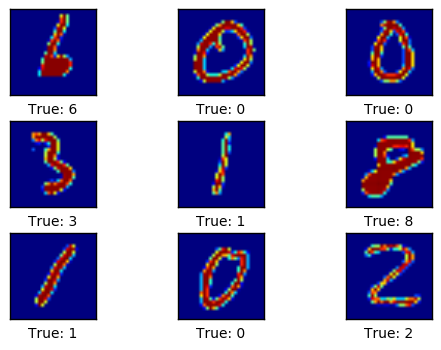

In [9]:
plot_images(x_train[:,:,:,0], y_train, cls_pred=None)

# Test data view

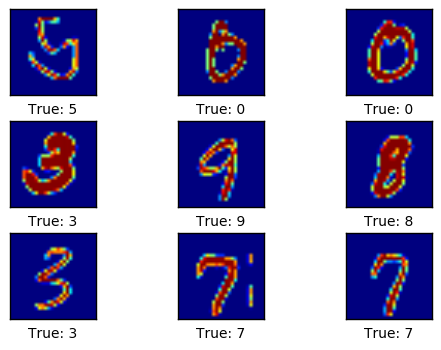

In [10]:
plot_images(x_test[:,:,:,0], y_test, cls_pred=None)

# Model architecture

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Train model

In [12]:
model.fit(x_train_, y_train_,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_, y_test_))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 482s 8ms/step - loss: 1.9746 - acc: 0.3489 - val_loss: 1.0462 - val_acc: 0.7071


# Test model

In [13]:
score = model.evaluate(x_test_, y_test_, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.04620927105
Test accuracy: 0.7071


# Show prediction results

In [14]:
def plot_example_errors_rights(cls_pred, correct):
    # This function is called from print_validation_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the validation set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the validation set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the validation set that have been
    # incorrectly classified.
    images_incorrect = x_test[incorrect,:,:,0]
    
    # Get the predicted classes for those images.
    cls_pred_incorrect = cls_pred[incorrect]

    # Get the true classes for those images.
    labels = y_test
    cls_true_incorrect = labels[incorrect]
    
    # Plot the first 9 images.
    print('Incorrect')
    plot_images(images=images_incorrect[0:9],
                cls_true=cls_true_incorrect[0:9],
                cls_pred=cls_pred_incorrect[0:9])
    
    # Get the images from the validation set that have been
    # incorrectly classified.
    images_correct = x_test[correct,:,:,0]
    
    # Get the predicted classes for those images.
    cls_pred_correct = cls_pred[correct]

    # Get the true classes for those images.
    cls_true_correct = labels[correct]
    
    print('Correct')
    plot_images(images=images_correct[0:9],
                cls_true=cls_true_correct[0:9],
                cls_pred=cls_pred_correct[0:9])

In [15]:
def print_validation_accuracy(show_example_errors_rights=False):
    
    cls_pred = np.array([np.argmax(x) for x in model.predict(x_test_)], dtype=np.int)
    
    # Convenience variable for the true class-numbers of the validation set.
    cls_true = y_test

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / len(y_test)

    # Print the accuracy.
    msg = "Accuracy on validation set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, len(y_test)))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors_rights:
        print("Example errors and rights:")
        plot_example_errors_rights(cls_pred=cls_pred, correct=correct)

# Results

Accuracy on validation set: 70.7% (7071 / 10000)
Example errors and rights:
Incorrect


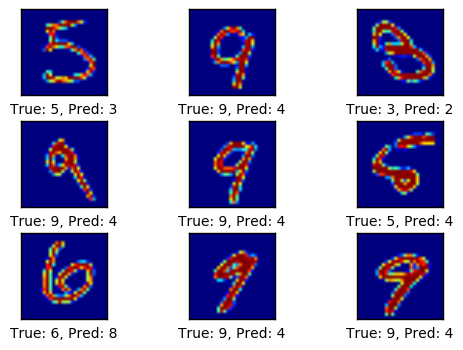

Correct


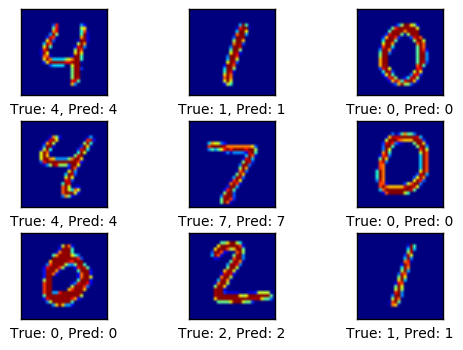

CPU times: user 26.5 s, sys: 1.05 s, total: 27.6 s
Wall time: 30.2 s


In [16]:
%%time

print_validation_accuracy(show_example_errors_rights=True)